Analyze qubit system response function and its dependence on the parameters.

If the system depends too much on its parameters, we will need a very high precision on the parameters; if it does not depend enough on the parameters, we will not learn the precise values because they are not important.

We look for a regime in which it makes sense to learn the parameters within our measurement budget (e.g. 100 measurements).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
import tensorflow_probability as tfp
from tqdm import tqdm, trange
import activelearning as al

%load_ext autoreload
%autoreload 2

2023-06-16 16:39:03.581789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
system = al.systems.get_system_from_name(al.systems.QubitsBinomial.__name__)(
                             dim_lambda=4,
                            #  type_lambda="all_ones",
                             real_lambda=np.ones([4])+np.random.randn(4)*0.1,
                             x_range=[0,5],
                             j_coupling=1.7)

2023-06-16 16:39:06.812840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22793 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


2023-06-16 16:39:08.070687: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x84f72f0


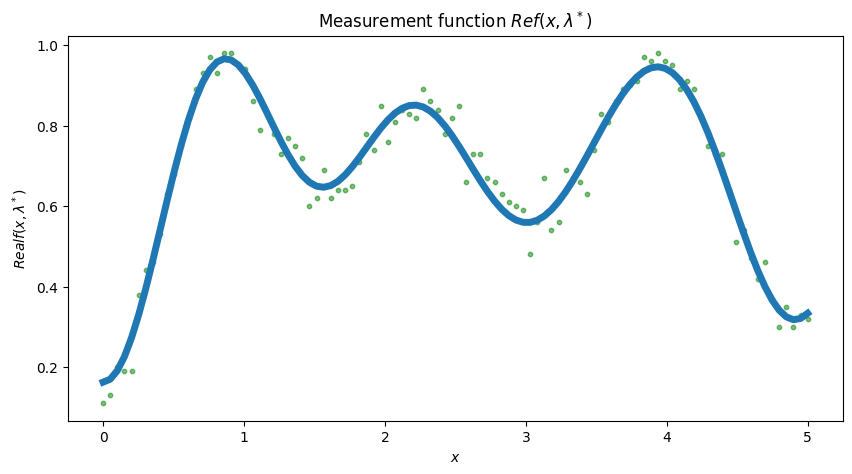

In [3]:
system.plot_response(PLOT_EXTENT=system.x_range)


In [4]:
learner = al.learners.BayesLearner.from_default(system)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-06-16 16:39:22.026075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-06-16 16:39:22.039888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'binomial_noncpu/while/uniform/stateless_random_uniform/StatelessRandomUniformV2/binomial_noncpu/concat' with dtype int32 and shape [3]
	 [[{{node binomial_noncpu/while/uniform/stateless_random_uniform/StatelessRandomUniformV2/binomial_noncpu/concat}}]]
2023-06-16 16:39:22.039971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an err

In [5]:
learner.prior = al.distributions.MultivariateGaussian(system.dim_lambda,tf.cast(tf.math.real(system.tf_real_lambda), K.backend.floatx()), 
                                                                             sigma=tf.eye(system.dim_lambda, dtype=K.backend.floatx())*1**2)

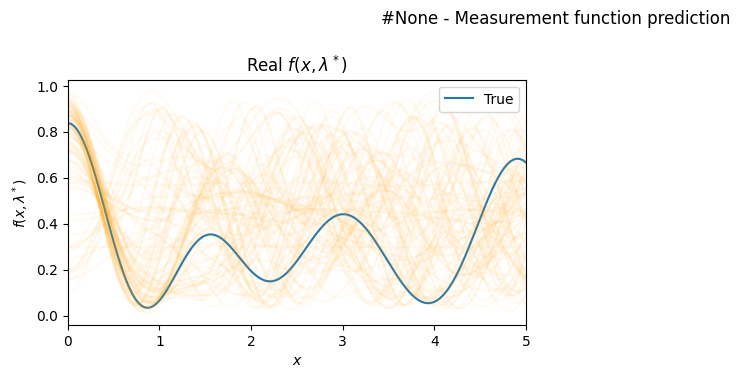

In [6]:
learner.plot_measurement_curve(None)


In [91]:
system

<class 'activelearning.systems.QubitsBinomial'>
tf_real_lambda           :	[1.16274736+0.j 1.00325196+0.j 1.04485431+0.j 0.91094373+0.j]
dim_system               :	4
x_range                  :	[0, 5]
frequencies              :	[1.0, 1.0, 1.0, 1.0]
excited_qubit_idx        :	0
measurement_idx          :	0
sigma_x                  :	[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
sigma_y                  :	[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]
sigma_z                  :	[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]
tf_n_qubits              :	(4+0j)
tf_frequencies           :	[1.+0.j 1.+0.j 1.+0.j 1.+0.j]
tf_coupling              :	(1.7+0j)
tf_alpha_pulse           :	(3.141592653589793+0j)
n_counts                 :	100

Parameters:
j_coupling               :	1.7
alpha_pulse              :	3.141592653589793

    

In [93]:
system.tf_f(0, system.tf_real_lambda)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.8385992 , 0.16140082]], dtype=float32)>

In [100]:
tf_x = 0
tf_lambda = system.tf_real_lambda
tf_complex = tf.complex128

In [103]:
tf_x_ = tf.cast(tf_x, tf_complex)  # represents evolution time
tf_lambda_ = tf.cast(tf_lambda, tf_complex)  # represents qubit frequencies

tf_H = system.tf_get_H(tf_lambda_, system.tf_coupling)
tf_psi_ground = system.tf_ground_state(tf_H)
tf_psi_excited = system.tf_apply_pulse(system.tf_alpha_pulse, tf_psi_ground)
tf_psi_evolved = system.tf_evolve_psi(tf_H, tf_psi_excited, tf_x_)

tf_probs = system.tf_get_probs(tf_psi_evolved)

In [104]:
tf_probs

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.16140082, 0.83859918]])>